In [2]:
!pip install yfinance
#https://pypi.org/project/yfinance/

In [3]:
import pandas as pd

In [4]:
import yfinance as yf
import datetime as dt

start = dt.datetime(2020,1,1)
end = dt.datetime.now()
btc = yf.Ticker('BTC-USD')
eth = yf.Ticker('ETH-USD')
gold = yf.Ticker('GC=F')

In [5]:
btc_history = btc.history(period="max")
eth_history = eth.history(period="max")
gold_history = gold.history(period='max')

# Bitcoin

In [6]:
data = btc_history.loc['2017-01-01':]
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-01-01,963.658020,1003.080017,958.698975,998.325012,147775008,0,0
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992,0,0
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000,0,0
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984,0,0
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008,0,0
...,...,...,...,...,...,...,...
2022-09-09,19328.140625,21439.410156,19310.962891,21381.152344,48469528171,0,0
2022-09-10,21376.912109,21760.275391,21168.722656,21680.539062,36913738894,0,0
2022-09-11,21678.542969,21770.552734,21406.945312,21769.255859,34493951963,0,0


# ARIMA

## Train test split for baseline model

In [8]:
train_size =0.9

index = round(train_size*data['Close'].shape[0])

data_train = data['Close'].iloc[:index]
data_test = data['Close'].iloc[index:]

In [15]:
len(data_train), len(data_test)

(1874, 208)

## Predict next day

In [9]:
y_pred = data_test.shift(1)
y_pred

Date
2022-02-18             NaN
2022-02-19    40030.976562
2022-02-20    40122.156250
2022-02-21    38431.378906
2022-02-22    37075.281250
                  ...     
2022-09-09    19329.833984
2022-09-10    21381.152344
2022-09-11    21680.539062
2022-09-12    21769.255859
2022-09-14    22370.449219
Name: Close, Length: 208, dtype: float64

In [11]:
from sklearn.metrics import r2_score

y_pred = data_test.shift(1).dropna()
y_true = data_test[1:]

print(f"R2: {r2_score(y_true, y_pred)}")

R2: 0.9843879037466573


## Decomposition

In [12]:
#data_2.Date.diff().value_counts()

data = data.iloc[:-1]

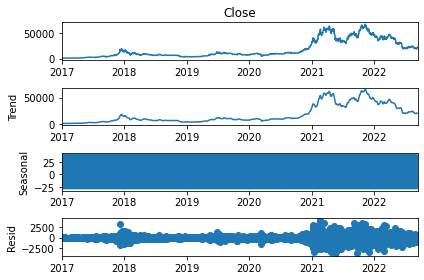

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_add = seasonal_decompose(data['Close'], model='additive')
result_add.plot();

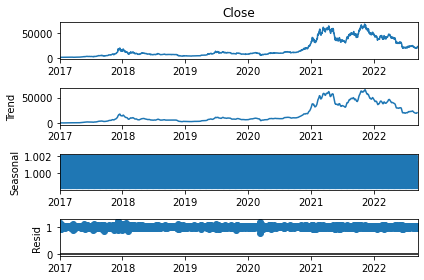

In [14]:
result_mul = seasonal_decompose(data['Close'], model='multiplicative')
result_mul.plot();

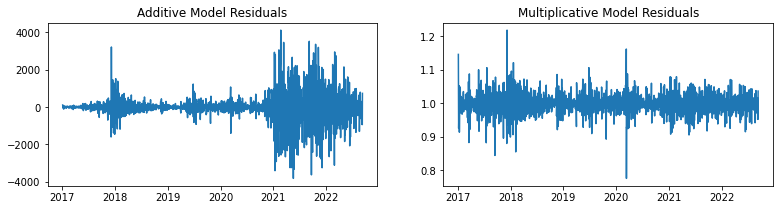

In [16]:
import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(1,2, figsize=(13,3))
ax1.plot(result_add.resid); ax1.set_title("Additive Model Residuals")
ax2.plot(result_mul.resid); ax2.set_title("Multiplicative Model Residuals");

## Adfuller

In [17]:
from  statsmodels.tsa.stattools import adfuller

adfuller(data.Close)[1]

0.5289257199410394

In [18]:
print('additive resid: ', adfuller(result_add.resid.dropna())[1])
print('multiplicative resid: ', adfuller(result_mul.resid.dropna())[1])

additive resid:  1.676491012776986e-29
multiplicative resid:  3.816917279268034e-27


## ACF and PACF

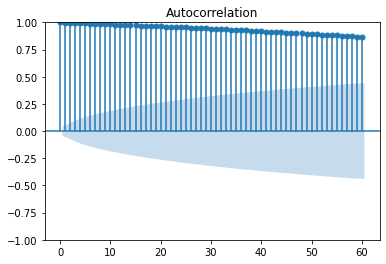

In [19]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data.Close, lags=60)
plt.show()

/Users/invite/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


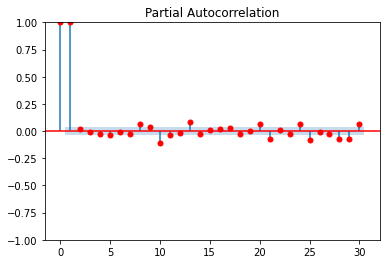

In [20]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(btc_history.Close, lags=30, c='r');

## DIFF

In [21]:
difference_1 = data['Close'].diff()
difference_1

Date
2017-01-01            NaN
2017-01-02      23.424988
2017-01-03      22.089966
2017-01-04     110.890015
2017-01-05    -141.349976
                 ...     
2022-09-08      39.509766
2022-09-09    2051.318359
2022-09-10     299.386719
2022-09-11      88.716797
2022-09-12     601.193359
Name: Close, Length: 2081, dtype: float64

In [22]:
difference_1.diff()

Date
2017-01-01            NaN
2017-01-02            NaN
2017-01-03      -1.335022
2017-01-04      88.800049
2017-01-05    -252.239990
                 ...     
2022-09-08    -413.146484
2022-09-09    2011.808594
2022-09-10   -1751.931641
2022-09-11    -210.669922
2022-09-12     512.476562
Name: Close, Length: 2081, dtype: float64

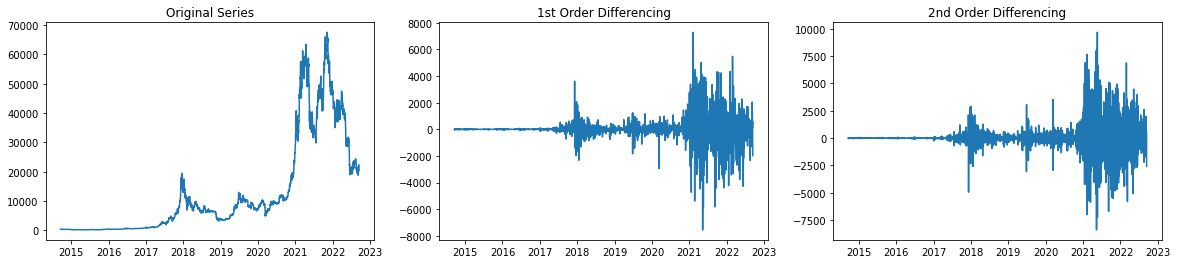

In [23]:
zero_diff = btc_history['Close']
first_order_diff = btc_history['Close'].diff()
second_order_diff = btc_history['Close'].diff(1).diff(1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
ax1.plot(zero_diff); ax1.set_title('Original Series')
ax2.plot(first_order_diff); ax2.set_title('1st Order Differencing')
ax3.plot(second_order_diff); ax3.set_title('2nd Order Differencing');

In [24]:
data['Deseasonalized'] = data.Close.values/result_mul.seasonal

/var/folders/x6/36rt5cz91tsdc2y_c9095w4c0000gp/T/ipykernel_24762/3511641096.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Deseasonalized'] = data.Close.values/result_mul.seasonal


/var/folders/x6/36rt5cz91tsdc2y_c9095w4c0000gp/T/ipykernel_24762/133484456.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Linearized'] = np.log(data['Deseasonalized'])


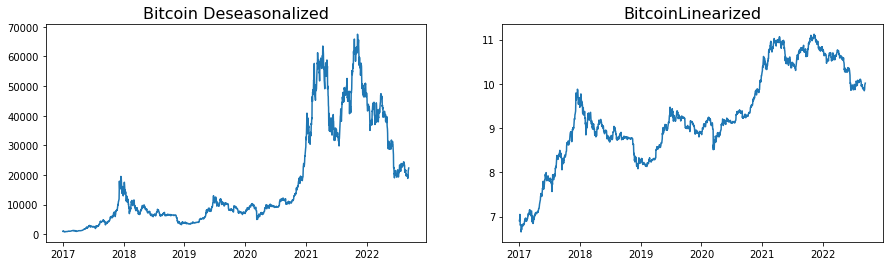

In [25]:
import numpy as np
plt.figure(figsize=(15,4)); plt.subplot(1,2,1); plt.plot(data.Deseasonalized);
plt.title('Bitcoin Deseasonalized', fontsize=16);

# Also remove exponential trend 
data['Linearized'] = np.log(data['Deseasonalized'])

plt.subplot(1,2,2); plt.plot(data['Linearized'])
plt.title('BitcoinLinearized', fontsize=16);

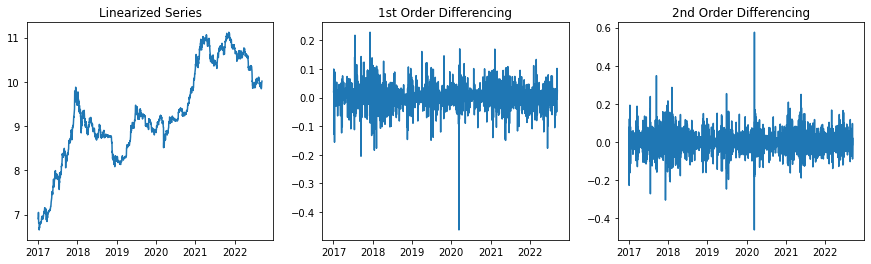

In [26]:
fig, axes = plt.subplots(1, 3,figsize=(15,4))

axes[0].plot(data['Linearized']); axes[0].set_title('Linearized Series')
# 1st Differencing
y_diff = data['Linearized'].diff().dropna()
axes[1].plot(y_diff); axes[1].set_title('1st Order Differencing')

# 2nd Differencing
y_diff_diff = data['Linearized'].diff().diff().dropna()
axes[2].plot(y_diff_diff); axes[2].set_title('2nd Order Differencing');

In [27]:
print('p-value zero-diff: ', adfuller(data['Linearized'])[1])
print('p-value first-diff: ', adfuller(data['Linearized'].diff().dropna())[1])
print('p-value second-diff: ', adfuller(data['Linearized'].diff().diff().dropna())[1])

p-value zero-diff:  0.23850157741413353
p-value first-diff:  0.0
p-value second-diff:  2.920747389660084e-27


In [28]:
from pmdarima.arima.utils import ndiffs
ndiffs(data['Linearized'])

1

/Users/invite/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


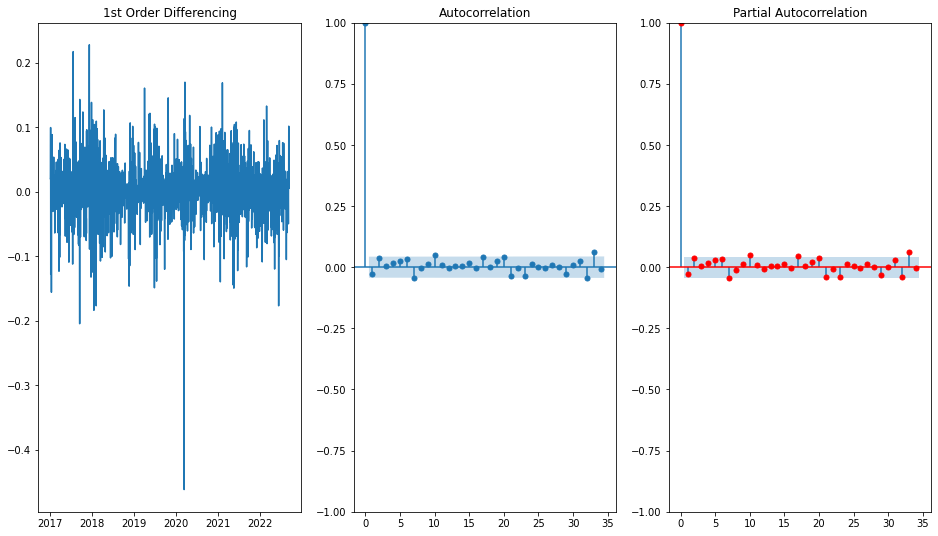

In [29]:
fig, axes = plt.subplots(1,3, figsize=(16,9))
axes[0].plot(y_diff); axes[0].set_title('1st Order Differencing')
plot_acf(y_diff, ax=axes[1]);
plot_pacf(y_diff, ax=axes[2], c='r');

## Train test split for my model

In [31]:
train_size =0.9

index = round(train_size*data['Linearized'].shape[0])

train = data['Linearized'].iloc[:index]
test = data['Linearized'].iloc[index:]

In [34]:
len(train), len(test)

(1873, 208)

In [44]:
index

1873

## Model

In [35]:
from statsmodels.tsa.arima.model import ARIMA

In [36]:
arima = ARIMA(train, order=(0,1,0),trend='t')
arima = arima.fit()

/Users/invite/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/invite/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/invite/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [37]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Linearized   No. Observations:                 1873
Model:                 ARIMA(0, 1, 0)   Log Likelihood                3279.022
Date:                Wed, 14 Sep 2022   AIC                          -6554.043
Time:                        11:58:47   BIC                          -6542.974
Sample:                    01-01-2017   HQIC                         -6549.965
                         - 02-16-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0020      0.001      2.032      0.042    7.15e-05       0.004
sigma2         0.0018   2.35e-05     74.874      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   1.42   Jarque-Bera (JB):              8779.13
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
import pmdarima as pm
smodel = pm.auto_arima(train,
                       start_p=1, max_p=2,
                       start_q=1, max_q=2,
                       trend='t',
                       seasonal=False,
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6550.076, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6551.827, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6551.127, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6551.008, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6551.827, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.582 seconds


In [39]:
forecast = arima.forecast(len(test), alpha=0.05)
forecast_results = arima.get_forecast(len(test), alpha=0.05)

forecast = forecast_results.predicted_mean
confidence_int = forecast_results.conf_int().values

In [41]:
len(forecast), len(confidence_int), len(test)

(208, 208, 208)

In [42]:
# We define here a "Plot forecast vs. real", which also shows historical training set

def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

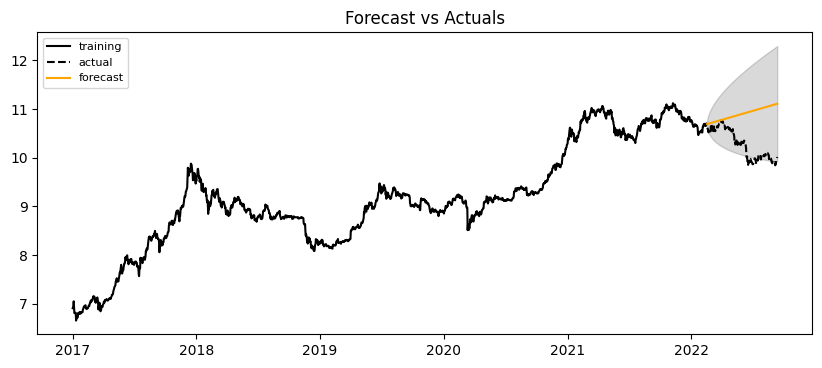

In [43]:
plot_forecast(forecast, train, test, confidence_int[:,0], confidence_int[:,1])

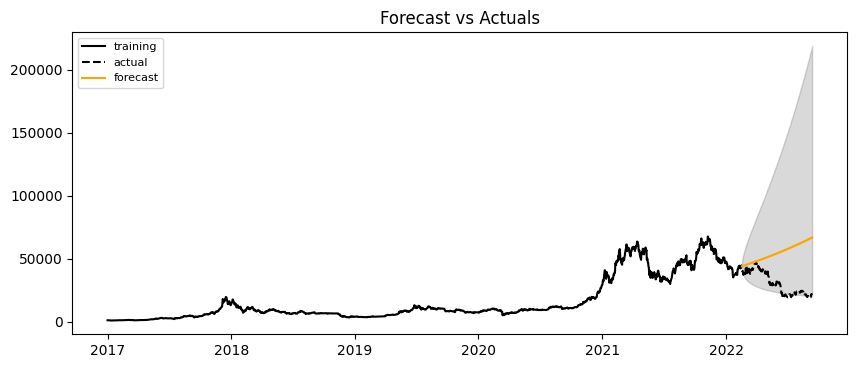

In [45]:
forecast_recons = np.exp(forecast) * result_mul.seasonal[index:]
train_recons = np.exp(train) * result_mul.seasonal[0:index]
test_recons = np.exp(test) * result_mul.seasonal[index:]
lower_recons = np.exp(confidence_int)[:, 0] * result_mul.seasonal[index:]
upper_recons = np.exp(confidence_int)[:, 1] * result_mul.seasonal[index:]

# Plot
plot_forecast(forecast_recons, train_recons, test_recons, lower_recons.values, upper_recons.values)

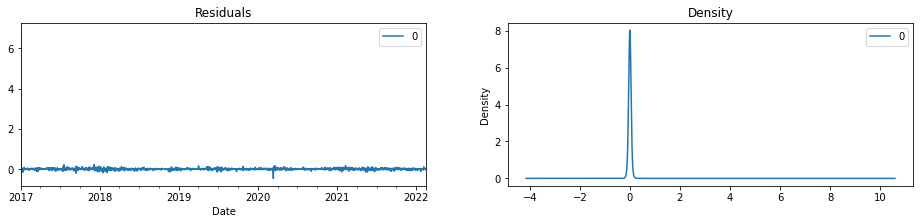

In [46]:
residuals = pd.DataFrame(arima.resid)

fig, ax = plt.subplots(1,2, figsize=(16,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1]);

# Sarima

/var/folders/x6/36rt5cz91tsdc2y_c9095w4c0000gp/T/ipykernel_24762/63177883.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['log'] = np.log(data.Close)


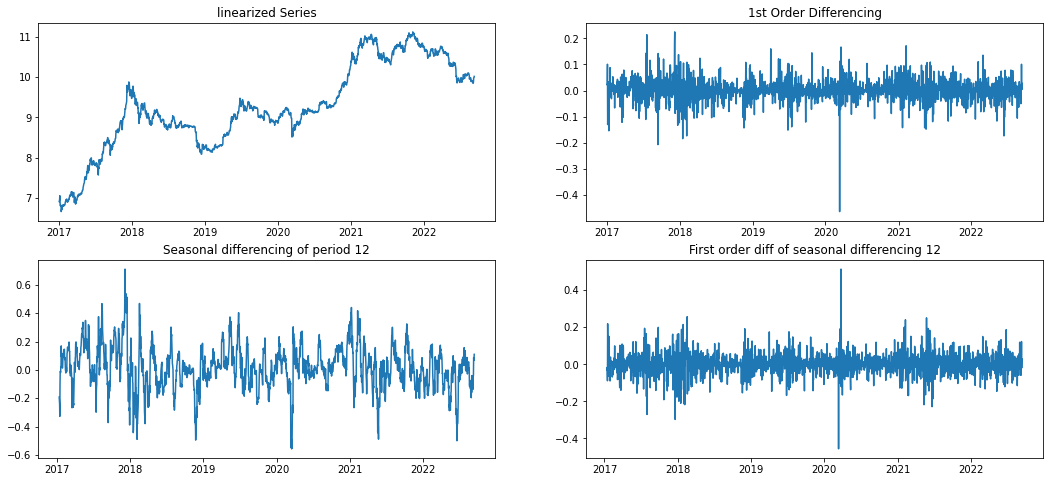

In [49]:
fig, axs = plt.subplots(2, 2, figsize=(18,8))
# keeping just log transform to stay ~ linear
data['log'] = np.log(data.Close)

# linearized series
axs[0,0].plot(data.log); axs[0,0].set_title('linearized Series')

# Normal differencing
axs[0,1].plot(data.log.diff(1)); axs[0,1].set_title('1st Order Differencing')

# Seasonal differencing
axs[1,0].plot(data.log.diff(12))
axs[1,0].set_title('Seasonal differencing of period 12')

# Sesonal + Normal differencing
axs[1,1].plot(data.log.diff(12).diff(1))
axs[1,1].set_title('First order diff of seasonal differencing 12');

In [50]:
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Deseasonalized,Linearized,log
Date,,,,,,,,,,
2017-01-01,963.658020,1003.080017,958.698975,998.325012,147775008,0,0,1000.039760,6.907795,6.906079
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992,0,0,1020.507952,6.928056,6.929272
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000,0,0,1043.244378,6.950091,6.950661
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984,0,0,1152.354101,7.049562,7.051622
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008,0,0,1014.052133,6.921710,6.921047


In [59]:
train = data['log'].iloc[:index]
test = data['log'].iloc[index:]

In [60]:
smodel = pm.auto_arima(train, seasonal=True, m=12, 
                       start_p=0, max_p=1, max_d=1, start_q=0, max_q=1,
                       start_P=0, max_P=2, max_D=1, start_Q=0, max_Q=2, 
                       trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-6550.164, Time=0.16 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-6547.717, Time=0.51 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-6547.622, Time=1.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-6547.836, Time=0.06 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-6548.164, Time=0.20 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-6548.174, Time=0.44 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-6546.244, Time=0.51 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-6549.708, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-6549.613, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-6549.032, Time=0.24 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12] intercept
Total fit time: 3.758 seconds


In [61]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima = SARIMAX(train, order=(0,1,0), seasonal_order=(0,0,0,12))
sarima = sarima.fit()

results = sarima.get_forecast(len(test), alpha=0.05)
forecast = results.predicted_mean
confidence_int = results.conf_int()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.74849D+00    |proj g|=  7.04223D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2     14      1     0     0   3.641D-04  -1.748D+00
  F =  -1.7484879299423259     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/invite/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/invite/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


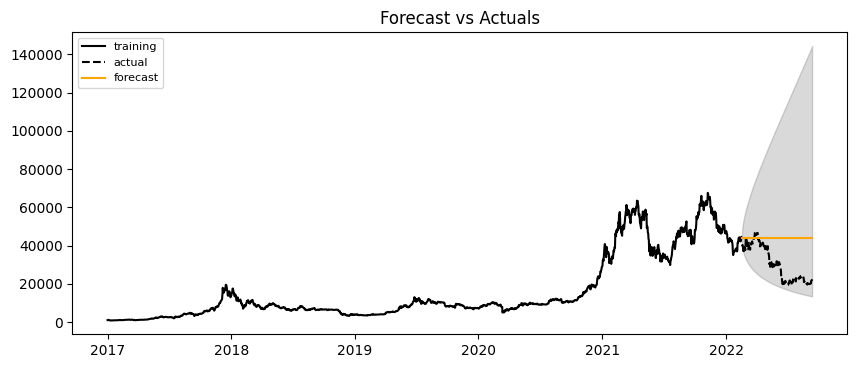

In [62]:
forecast_recons = pd.Series(np.exp(forecast), index=test.index)
lower_recons = np.exp(confidence_int['lower log']).values
upper_recons = np.exp(confidence_int['upper log']).values

plot_forecast(forecast_recons, np.exp(train), np.exp(test), upper = upper_recons, lower=lower_recons)

In [63]:
!pwd

/Users/invite/code/MahamadouNiakate/crypto_pred/notebooks


In [64]:
gst

NameError: name 'gst' is not defined